<a id='toc'></a>
# Table of Contents:
1. [Make Graph](#makegraph)
2. [Read in Yearly Prediction and Scale Back to Original Interval](#readscale)
3. [Exploratory Data Analysis](#eda) <br>
    3.1 [Data Wrangling](#wrangling) <br>
    3.2 [Calculating Per-Node Error](#node-error) <br>
    3.3 [Calculating Per-Pipe Error](#pipe-error) <br>
    3.4 [Leakage Labelset](#leaks) <br>
    3.5 [Dataset Pre-Processing](#pre-process) <br>
5. [Boem et al. Residual Analysis](#residual)

# Leak Detection

> Garðar Örn Garðarsson <br>
Integrated Machine Learning Systems 20-21 <br>
University College London

<a id='makegraph'></a>
*Back to [Table of Contents](#toc)*

## 1. Make Graph

Convert the `EPANET` model to a `networkx` graph

In [1]:
import os
import yaml
import time
import torch
import epynet
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.epanet_loader import get_nx_graph
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator, embedSignalOnGraph, rescaleSignal
from modules.torch_gnn import ChebNet
from utils.visualisation import visualise

# Runtime configuration
path_to_wdn     = './data/L-TOWN.inp'
path_to_data    = './data/l-town-data/'
weight_mode     = 'pipe_length'
self_loops      = True
scaling         = 'minmax'
figsize         = (50,16)
print_out_rate  = 1               
model_name      = 'l-town-chebnet-' + weight_mode +'-' + scaling + '{}'.format('-self_loop' if self_loops else '')
last_model_path = './studies/models/' + model_name + '-1.pt'
last_log_path   = './studies/logs/'   + model_name + '-1.csv' 

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode=weight_mode, get_head=True)

<a id='readscale'></a>
*Back to [Table of Contents](#toc)*

## 2. Read in Yearly Prediction and Scale Back to Original Interval

In [2]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df = pd.read_csv(filename, index_col='Unnamed: 0')
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns]
    df = df*scale+bias
    df.index = pd.date_range(start=start_date,
                             periods=len(df),
                             freq = '5min')
    return df

In [3]:
n_timesteps = 3                                              # Timesteps, t-1, t-2...t-n used to predict pressure at t
sample_rate = 5                                              # Minutes sampling rate of data
offset      = pd.DateOffset(minutes=sample_rate*n_timesteps) # We require n_timesteps of data our first prediction

Load predictions

In [4]:
p18 = read_prediction(filename='2018_predictions.csv',
                      start_date=pd.Timestamp('2018-01-01 00:00:00') + offset)

Load reconstructions

In [5]:
r18 = read_prediction(filename='2018_reconstructions.csv',
                      start_date='2018-01-01 00:00:00')

Load leakage dataset

In [6]:
l18 = pd.read_csv('data/l-town-data/2018_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
l18.index = r18.index # Fix the index column timestamp format

<a id='eda'></a>
*Back to [Table of Contents](#toc)*

## 3. Exploratory Data Analysis

<a id='wrangling'></a>
*Back to [Table of Contents](#toc)*

### 3.1 Data Wrangling & Helper Functions

Lets create a dictionary of the format:

`{ 'pipe_name' : [ connected_node_1 , connected_node_2 ] }`

For all the pipes in the network

In [7]:
neighbours_by_pipe = {}

for node in G:
    for neighbour, connecting_edge in G[node].items():
        if connecting_edge['name'] == 'SELF':
            continue
        else:
            neighbours_by_pipe[connecting_edge['name']] = [node, neighbour]
            

Let's also create the inverse, when we want to look up pipes by their connecting nodes

In [8]:
pipe_by_neighbours = { str(neighbour_list) : pipe for pipe , neighbour_list in neighbours_by_pipe.items()}

Collect timestamp of leakage events in the network

In [9]:
leak_timestamps = {}

for leak in l18:
    leak_timestamps[leak] = l18.index[l18[leak]>0]

A function for returning a list of nodes and pipes in the $k$-neighbourhood of a given pipe

In [10]:
def discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, graph, k=3):
    
    leaky_nodes = neighbours_by_pipe[pipe]
    
    node_1_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[0], cutoff=k)
    node_2_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[1], cutoff=k)
    
    n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]

    pipes_in_neighbourhood = []                                                    # List of neighbourhood pipes
    for neighbour1 in n_hop_neighbours:                                            # For neighbour 1 
        for neighbour2 in n_hop_neighbours:                                        # For neighbour 2
            pipe = pipeByneighbourLookup(neighbour1,neighbour2,pipe_by_neighbours) # Look for a connecting pipe ...
            if pipe:                                                               # ... with the neighbours and if found:
                pipes_in_neighbourhood.append(pipe)                                # .... add it to the list
    
    pipes_in_neighbourhood = list(dict(zip(pipes_in_neighbourhood,[pipes_in_neighbourhood.count(i) for i in pipes_in_neighbourhood])).keys())
    
    return pipes_in_neighbourhood, n_hop_neighbours

We'll also create a function to perform the lookup, as the order in which the nodes appear in the key matter and we don't bother with raising endless errors when looking up nodes we know to be connected, just cause we input them wrong

In [11]:
def pipeByneighbourLookup(node1, node2, pipe_by_neighbours, verbose=False):
    try:
        return pipe_by_neighbours[str([node1,node2])]    # If we don't find the first combination
    except:
        try:                                            # We try the next
            return pipe_by_neighbours[str([node2,node1])]
        except:                                         # And if we still don't find it
            if verbose:
                print('Nodes are not connected by a pipe')
            return None                                 # We return nothing

A function for determining the numeric value of a timestring window

In [12]:
def determineWindowSize(window='5d',sampling_rate='5min'):
    return int(pd.Timedelta(window) / pd.Timedelta(sampling_rate))

Wrap this all to a single function:

<a id='node-error'></a>
*Back to [Table of Contents](#toc)*

### 3.2 Calculating Per-Node Error

We may calculate the node-wise validation error, $\epsilon_{n_{i}}$, by subtracting the predicted values with the reconstructed ones.

In [13]:
error_by_node = (p18-r18).copy()

<a id='pipe-error'></a>
*Back to [Table of Contents](#toc)*

### 3.3 Calculating Per-Pipe Error

We may calculate the pipe-wise validation errors, $\epsilon_{p_i}$, as the difference of the validation error of the two nodes connecting the pipe

In [14]:
error_by_pipe = {}

for key,value in neighbours_by_pipe.items():
    node_1 = 'n' + str(value[0])
    node_2 = 'n' + str(value[1])
    error_by_pipe[key] = ( error_by_node[node_1] - error_by_node[node_2] )
    
error_by_pipe = pd.DataFrame(error_by_pipe)

<a id='pre-process'></a>
*Back to [Table of Contents](#toc)*

### 3.5 Dataset Pre-Processing

Process the dataset for timeseries classification. <br>
I want to devise a set where I have a configurable window of observations, `[1, 5, 10, ... 200]`.<br>
For that window of observations, I sum the per pipe events such that the according label will read `[0, 0, 1, 0, ...]`, where the set bit indicates the leaky pipes for that interval. <br>

First clean out the `NaNs` from the feature and labelset caused by the window size of the predictive model

In [15]:
error_by_pipe = error_by_pipe.dropna()

Similarly for the pipe-wise classification, do it for the node-wise classification

In [16]:
error_by_node = error_by_node.dropna()

<a id='residual'></a>
*Back to [Table of Contents](#toc)*

## 4. Boem et al. Residual Analysis

Configure parameters:

\begin{equation}
m = \frac{ 7~\text{days} }{ 5~\text{minutes} } = 2016
\end{equation}

\begin{equation}
\alpha = 1 
\end{equation}

In [61]:
window  = '7d'
wdw_int = determineWindowSize(window,sampling_rate='5min')
min_per = determineWindowSize('7d' ,sampling_rate='5min')
alpha   = 2

print("m:\t{}\nalpha:\t{}".format(wdw_int,alpha))

m:	2016
alpha:	2


Standardise the signals to be analysed, by subtracting the mean and dividing by the std.dev:

\begin{equation}
S(k) = \frac{\epsilon_i - \mu_{\epsilon_i} } { \sigma_{\epsilon_i}}
\end{equation}

❗️**The signal should only be standardised if it's stationary** ❗️

In [62]:
from statsmodels.tsa.stattools import adfuller

def augmentedDickeyFuller(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    # Interpret test results
    if dfoutput['p-value'] > 0.05:
        dfoutput['Interpretation'] = '| p > 0.05 | Fail to reject H0 | Data is non-stationary |'
    else: 
        dfoutput['Interpretation'] = '| p <= 0.05 | Reject H0 | Data is stationary |'
    print (dfoutput)

❗️**The signal should only be standardised from data under healthy condition** ❗️

So we could use this to retrieve a list of date-time indices that denote faulty condition, for neighbouring pipes of leakages, that we then leave-out from the standardisation of the signal.

In [63]:
k = 6           # k-hop neighbourhood of a leaky pipe
fault_times = {}

# First populate the key variable with empty lists, that are the k-hop neighbouring nodes of leaky pipes:
for leaky_pipe in leak_timestamps.keys():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe] = []

So there are in fact:

In [64]:
len(fault_times.keys())

517

Now that we've initialised the dictionary with empty lists, we can again iterate through the `leak_timestamps` and append them to the lists, thereby, taking care of not overwriting recurring nodes:

*Note: recurring nodes, would be nodes that are in the $k$ neighbourhood of more than one leakages*

In [65]:
for leaky_pipe, time in leak_timestamps.items():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe].append(time)

In [66]:
pipe_with_most_faulty_periods = ''
most_faults_found_in_a_pipe   = 0

for pipe, dt_list in fault_times.items():
    n_faulty_periods = len(dt_list)
    
    if n_faulty_periods > most_faults_found_in_a_pipe:
        pipe_with_most_faulty_periods = pipe
        most_faults_found_in_a_pipe   = n_faulty_periods
        
print('Pipe {} was the {}-hop neighbour to {} leakages'.format(pipe_with_most_faulty_periods,
                                                               k,
                                                               most_faults_found_in_a_pipe))

Pipe p632 was the 6-hop neighbour to 3 leakages


In [67]:
faulty_avg = {}
faulty_std = {}

for pipe, dt_list in fault_times.items():
    
    n_faulty_periods = len(dt_list)
    
    # Some ugly hardcoding
    if n_faulty_periods == 1:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0])].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0])].std()
        
    if n_faulty_periods == 2:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) ].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) ].std()
    if n_faulty_periods == 3:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) ].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) ].std()
    if n_faulty_periods == 4:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][3]) ].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][3]) ].std()


Now for the healthy pipes:

In [68]:
healthy_avg = {}
healthy_std = {}

for pipe in error_by_pipe:
    if pipe in faulty_avg:
        continue
    else:
        healthy_avg[pipe] = error_by_pipe[pipe].mean()
        healthy_std[pipe] = error_by_pipe[pipe].std()

And standardise the residual signals given these averages and std.devs:

In [69]:
signal = pd.DataFrame([])
for pipe in error_by_pipe:
    if pipe in faulty_avg.keys():
        signal[pipe] = (error_by_pipe[pipe] - faulty_avg[pipe]) #/ faulty_std[pipe]
    else:
        signal[pipe] = (error_by_pipe[pipe] - healthy_avg[pipe]) # / healthy_std[pipe]

Let's store a copy of these that may come in handy later

In [70]:
avg = pd.concat([pd.DataFrame(healthy_avg, index=[0]),
                 pd.DataFrame(faulty_avg, index=[0])],
                 axis=1)[error_by_pipe.columns]

In [71]:
std = pd.concat([pd.DataFrame(healthy_std, index=[0]),
                 pd.DataFrame(faulty_std, index=[0])],
                 axis=1)[error_by_pipe.columns]

In [72]:
avg.to_csv('pipe_avg.csv')
std.to_csv('pipe_std.csv')

The signal to be assessed is then the absolute value of the rolling mean of the standardised 
residual signal

\begin{equation}
|\bar{r}^{(m)}(k)| = \text{ABS} \left( \frac{1}{m} \sum_{i=0}^{m} S(k-i) \right)
\end{equation}

In [73]:
r_m_k = abs(signal.rolling(window,min_per).mean().dropna())

Now, for the threshold, we define it as: 

\begin{equation}
\bar{\rho}^{(m)}(k) = \alpha \bar{\sigma}^{(m)}(k)
\end{equation}

Where:

\begin{equation}
(\bar{\sigma}^{(m),B}(k))^2 = \frac{1}{m} \sum_{j=0}^{m-1} (\sigma^B(k-j))^2
\end{equation}

... or effectively, the threshold is some value $\alpha$ times the rolling standard deviation of the signal


In [74]:
threshold = {}

for pipe in error_by_pipe:
    threshold[pipe] = alpha * signal[pipe].rolling(window,min_per).std().dropna() # ALPHA !!!

threshold = pd.DataFrame(threshold)

In [75]:
faults = (r_m_k >= threshold).astype('int')

Analyse a single event, these pipes had leaks:

In [76]:
l18.columns

Index(['p31', 'p158', 'p183', 'p232', 'p257', 'p369', 'p427', 'p461', 'p538',
       'p628', 'p654', 'p673', 'p810', 'p866'],
      dtype='object')

Let's pick out a single pipe failure and inspect the signal and detection in the neighbourhood

In [77]:
discoverNeighbourhood(pipe='p232', 
                      neighbours_by_pipe=neighbours_by_pipe, 
                      pipe_by_neighbours=pipe_by_neighbours,
                      graph=G,
                      k=1)

(['p232', 'p621', 'p617', 'p431', 'p609', 'p611'],
 [191, 184, 586, 583, 465, 578, 579])

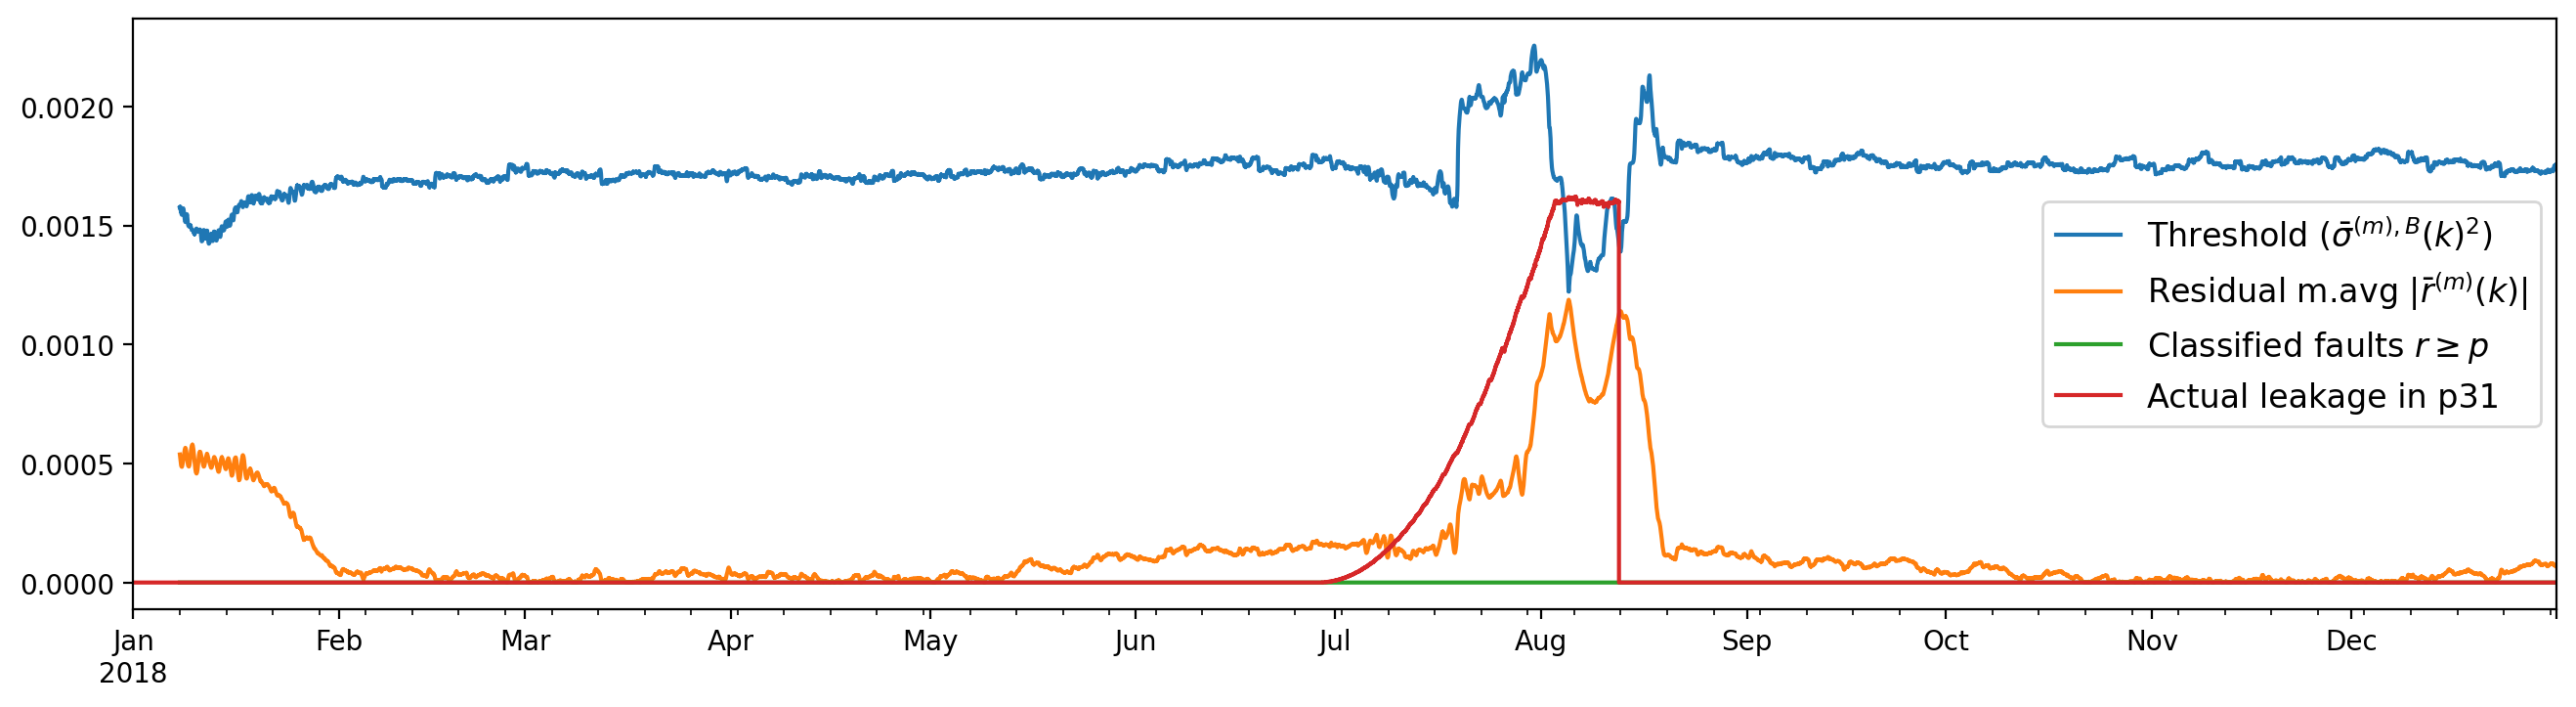

In [78]:
plt.figure(figsize=(16,4), dpi=200)

pipe = 'p31'
leak = 'p31'

# zoomed = leak_timestamps['p31']+pd.Timedelta(days=7)

threshold[   pipe].plot( label = r'Threshold $(\bar{\sigma}^{(m),B}(k)^2$)')
r_m_k[       pipe].plot( label = r'Residual m.avg $|\bar{r}^{(m)}(k)|$')
(1e-3*faults[pipe]).plot(label = r'Classified faults $r\geq p$')
(1e-4*l18[   leak]).plot(label =  'Actual leakage in {}'.format(leak))
plt.legend(prop={'size': 12})
#plt.title('Pipe: {}\nPipe leak @: {}'.format(pipe, leak))
plt.show()

Faults found in how many pipes (?)

In [36]:
len(faults.columns) - ((faults.sum()<=0).astype('int')).sum()
#  ^ total n pipes      ^ Mask out pipes with 0 faults   ^ and count them

528

Times of fault?

## 2018 Detections:

In [37]:
fault_times = {}

for pipe in faults:
    fault_times[pipe] = faults.index[faults[pipe]>0]


In [38]:
detections = {}
for pipe, timestamp in fault_times.items():
    if not timestamp.empty:
        detections[pipe] = timestamp[0]

In [ ]:
pruned_detections = {}

for key, val in detections.items():
    #check = 
    if val == pd.Timestamp('2018-01-08 00:10:00'):
        continue
    else:
        pruned_detections[key] = val

In [ ]:
sorted_detections = {k: v for k, v in sorted(pruned_detections.items(), key=lambda item: item[1])}

In [ ]:
for pipe, time in sorted_detections.items():
    nbors=discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=30)[0]
    break

In [ ]:
with open('results.txt', 'w') as f:
    f.write('#linkID, startTime\n')
    for key, val in sorted_detections.items():
        f.write(key + ', ' + str(sorted_detections[key])[:-3] + '\n')
    f.close()

## 2019 Detections:

In [ ]:
window  = '1d'
wdw_int = determineWindowSize(window,sampling_rate='5min')
min_per = determineWindowSize('1d' ,sampling_rate='5min')
alpha   = 1.5

print("m:\t{}\nalpha:\t{}".format(wdw_int,alpha))

In [ ]:
p19 = read_prediction(filename='2019_predictions.csv',
                      start_date=pd.Timestamp('2019-01-01 00:00:00') + offset)

In [ ]:
r19 = read_prediction(filename='2019_reconstructions.csv',
                      start_date='2019-01-01 00:00:00')

In [ ]:
l19 = pd.read_csv('data/l-town-data/2019_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
l19.index = r19.index # Fix the index column timestamp format

In [ ]:
error_by_node_19 = (p19-r19).copy()

In [ ]:
error_by_pipe_19 = {}

for key,value in neighbours_by_pipe.items():
    node_1 = 'n' + str(value[0])
    node_2 = 'n' + str(value[1])
    error_by_pipe_19[key] = ( error_by_node_19[node_1] - error_by_node_19[node_2] )
    
error_by_pipe_19 = pd.DataFrame(error_by_pipe_19)

In [ ]:
error_by_pipe_19 = error_by_pipe_19.dropna()

In [ ]:
signal = pd.DataFrame([])
for pipe in error_by_pipe_19:
    if pipe in faulty_avg.keys():
        signal[pipe] = (error_by_pipe_19[pipe] - faulty_avg[pipe]) #/ faulty_std[pipe]
    else:
        signal[pipe] = (error_by_pipe_19[pipe] - healthy_avg[pipe]) #/ healthy_std[pipe]

In [ ]:
r_m_k = abs(signal.rolling(window,min_per).mean().dropna())

In [ ]:
threshold = {}

for pipe in error_by_pipe_19:
    threshold[pipe] = alpha * signal[pipe].rolling(window,min_per).std().dropna() # ALPHA !!!

threshold = pd.DataFrame(threshold)

In [ ]:
faults_19 = (r_m_k >= threshold).astype('int')

In [ ]:
faults_19 = faults_19.diff(periods=1).fillna((faults_19.iloc[0]).astype('int'))

In [ ]:
detections_19 = {}

for pipe in faults_19:
    timestamp = faults_19[pipe].index[faults_19[pipe]>0]
    if timestamp.empty:
        continue
    else: 
        detections_19[pipe] = timestamp

In [ ]:
with open('results_data.txt', 'w') as f:
    f.write('#linkID, startTime\n')
    for key in detections_19.keys():
        for val in detections_19[key]: 
            f.write(key + ', ' + str(val)[:-3] + '\n')
    f.close()

In [ ]:
results = []
for key in detections_19.keys():
    for val in detections_19[key]:
        entry =[]
        entry.append(str(val)[:-3])
        entry.append(key)
        results.append(entry)

results = pd.DataFrame(results)
results.set_index(0,drop=True, inplace=True)

In [ ]:
results.to_csv('results_data.csv')

In [ ]:
len(detections_19.keys())

124 for $\alpha=2$

691 for $\alpha=1.5$

783 for $\alpha=1.0$

In [ ]:
detections = {}

In [ ]:
detections = pd.read_csv('results_data.csv', index_col = '0').sort_index()

In [ ]:
detections.index = pd.to_datetime(detections.index)

In [ ]:
detections['leakTimeStamp'] = detections.index

In [ ]:
detections = detections.resample('d').first()

In [ ]:
detections = detections.replace(to_replace='None', value=np.nan).dropna()

In [ ]:
detections.set_index('leakTimeStamp', drop=True, inplace=True)

In [ ]:
with open('results_data.txt', 'w') as f:
    f.write('#linkID, startTime\n')
    for time, pipe in detections['1'].to_dict().items():
        f.write(pipe + ', ' + str(time)[:-3] + '\n')
    f.close()

In [ ]:
detections.shape

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
gibberish_detections = np.random.randint(1,905,365)

In [ ]:
dateRange = pd.date_range("2019-01-01 00:00", periods = 365, freq='D')

In [ ]:
with open('random_results.txt', 'w') as f:
    f.write('#linkID, startTime\n')
    for pipe, time in zip(gibberish_detections, dateRange):
        f.write('p'+ str(pipe) + ', ' + str(time)[:-3] + '\n')
    f.close()

`(220, 1)` for $\alpha = 1.5$

`(317, 1)` for $\alpha = 1.0$